In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import napari
import os
from tifffile import imread
from glob import glob

sns.set(context='notebook', style='ticks')

In [12]:
# define paths
path_input = "../../Output/Measurements/"
path_output = "../../Output/Figures/"

# read data and prep data
df = (pd.read_csv(path_input + 'spots_by_threshold.csv')
    .assign(condition = lambda df_: df_.filename.str.split('-', expand=True)[1].str.split('_', expand=True)[0].str.replace('crtl', 'control'),
            foldername = lambda df_: df_.filename.str.split('-', expand=True)[0],
            nuclear_density = lambda df_: df_.nuclear_spots_number / df_.nuclei_volume,
            cyto_density = lambda df_: df_.cyto_spots_number / df_.cyto_volume,
            NCvolumeratio = lambda df_: df_.nuclei_volume / df_.cyto_volume,
            NCratio_volume = lambda df_: df_.NCratio * df_.NCvolumeratio,
            nuclear_spots_number_volume = lambda df_: df_.nuclear_spots_number * df_.NCvolumeratio,
            cyto_spots_number_volume = lambda df_: df_.cyto_spots_number * df_.NCvolumeratio)
)

# save data to disk
df.to_csv("../../Output/Measurements/spots_by_threshold_prepped.csv", index=False)

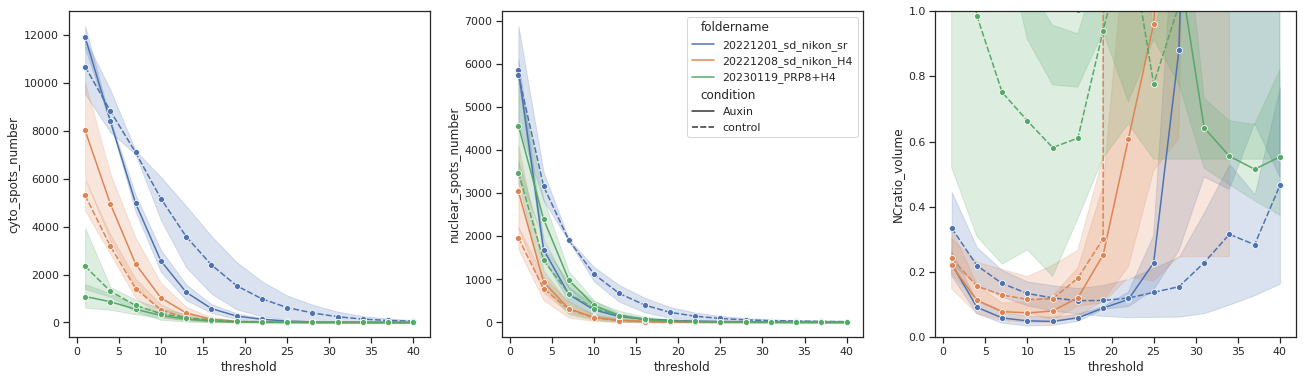

In [10]:
f, axes = plt.subplots(1,3, figsize=(22,6))
sns.lineplot(data=df, x='threshold', y='cyto_spots_number', marker='o', style='condition', hue='foldername', ax=axes[0], legend=False)
sns.lineplot(data=df, x='threshold', y='nuclear_spots_number', marker='o', style='condition', hue='foldername', ax=axes[1])
sns.lineplot(data=df, x='threshold', y='NCratio_volume', marker='o', style='condition', hue='foldername', ax=axes[2], legend=False).set(ylim=(0,1))
plt.show()

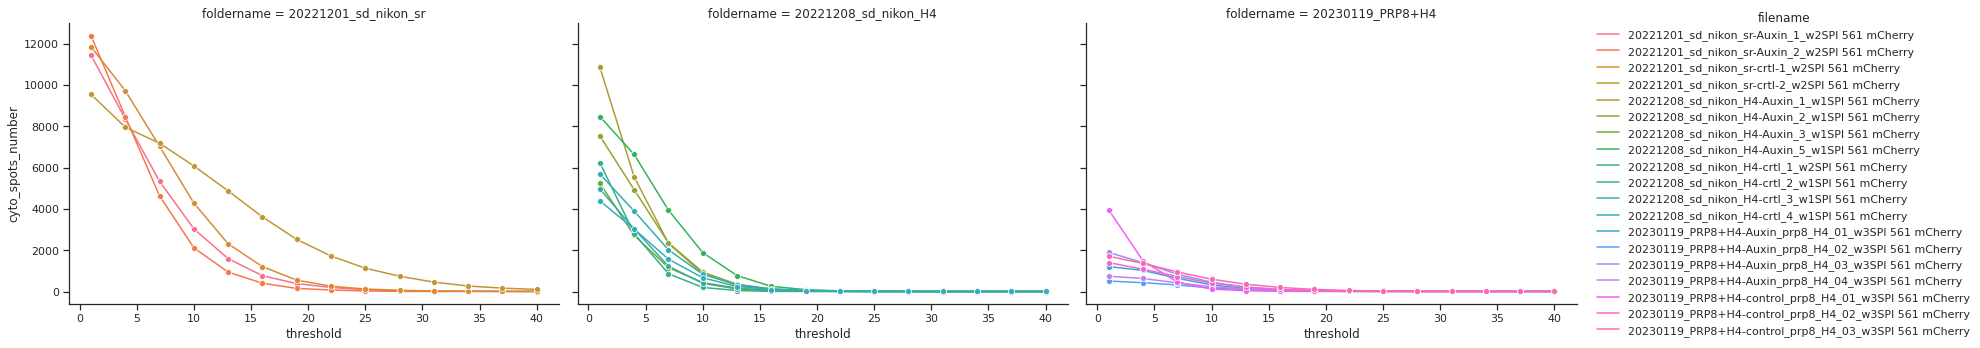

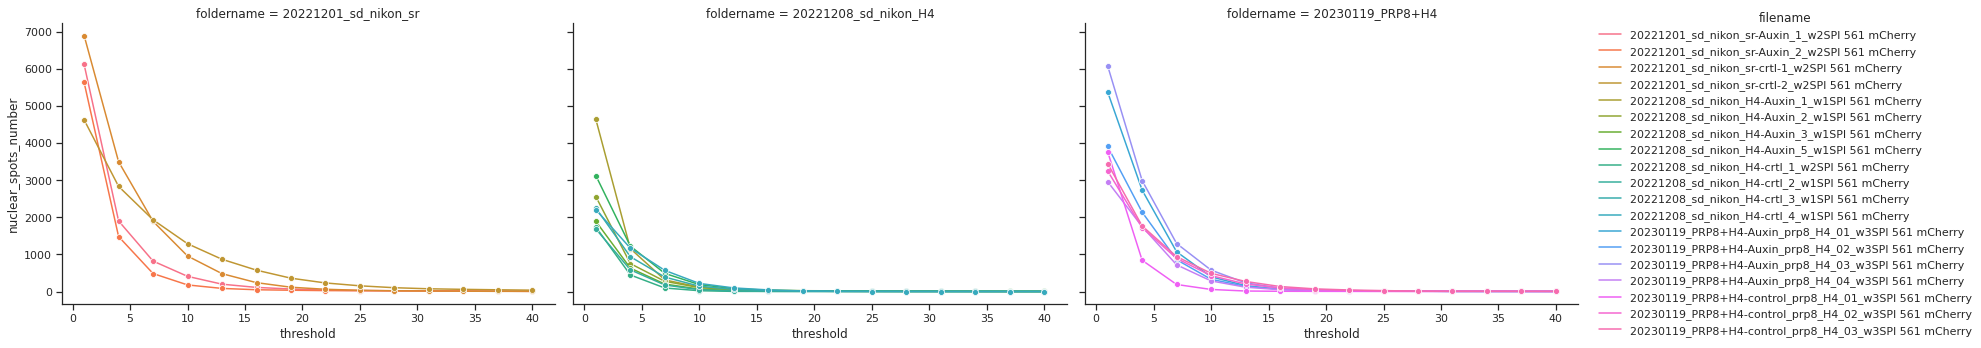

In [20]:
sns.relplot(data=df, x='threshold', y='cyto_spots_number', marker='o', kind='line', hue='filename', col='foldername', aspect=1.5)
sns.relplot(data=df, x='threshold', y='nuclear_spots_number', marker='o', kind='line', hue='filename', col='foldername', aspect=1.5)
plt.show()

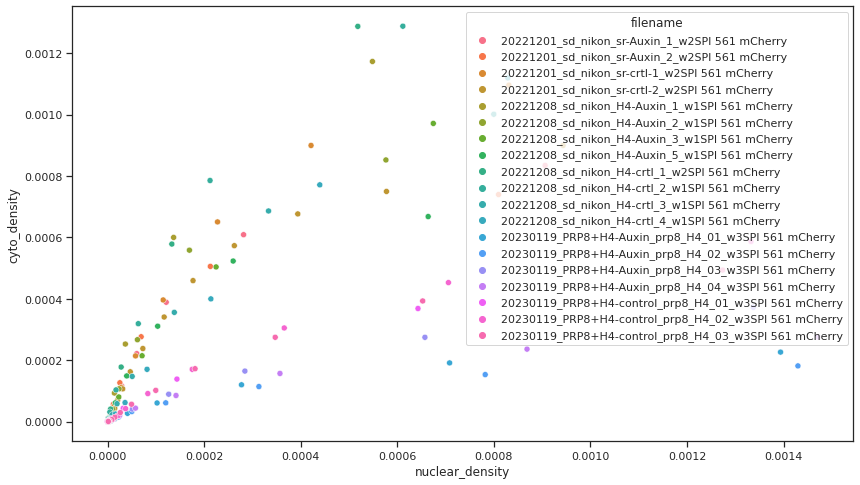

In [26]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=df, x='nuclear_density', y='cyto_density', hue='filename')
plt.show()

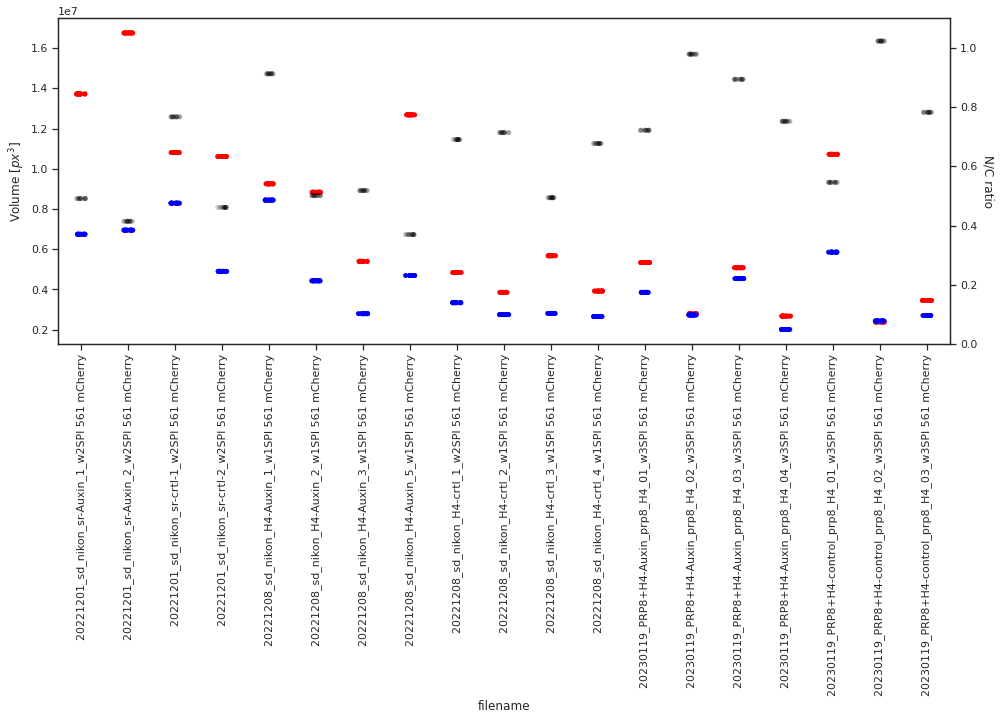

In [29]:
f, ax = plt.subplots(1, figsize=(16,6))
sns.stripplot(data=df, x='filename', y='cyto_volume', label='cyto', color='red', ax=ax)
sns.stripplot(data=df, x='filename', y='nuclei_volume', label='nuc', color='blue', ax=ax)
ax2 = ax.twinx()
ax2.set_ylim(0,1.1)
sns.stripplot(data=df, x='filename', y='NCvolumeratio', color='black', alpha=0.2, ax=ax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Volume [$px^3$]')
ax2.set_ylabel('N/C ratio', rotation=-90, va='bottom')
plt.show()

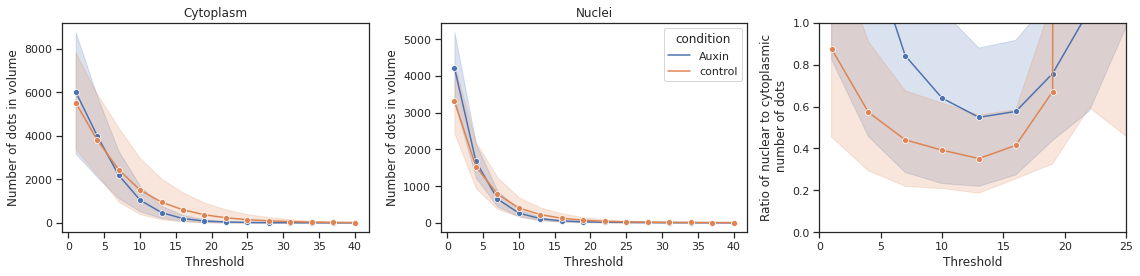

In [24]:
f, axes = plt.subplots(1,3, figsize=(16, 4))
sns.lineplot(data=df, x='threshold', y='cyto_spots_number', hue='condition', ax=axes[0], legend=False, marker='o')
g = sns.lineplot(data=df, x='threshold', y='nuclear_spots_number', hue='condition', ax=axes[1], marker='o', legend=True)
sns.lineplot(data=df, x='threshold', y='NCratio', hue='condition', ax=axes[2], marker='o', legend=False)
axes[2].set(ylim=(0,1))
axes[2].set(xlim=(0,25))
axes[0].set(xlabel='Threshold', ylabel='Number of dots in volume', title='Cytoplasm')
axes[1].set(xlabel='Threshold', ylabel='Number of dots in volume', title='Nuclei')
axes[2].set(xlabel='Threshold', ylabel='Ratio of nuclear to cytoplasmic\n number of dots')

# for ax in axes[:2]:
#     ax.set_yscale('log')
plt.tight_layout()
# plt.savefig(path_output + 'ncratio_by_condition.pdf')

In [6]:
# Filter detected spots using mask
def filter_spots(spots, mask):
    filter = np.bool8(mask[spots[:, 0], spots[:, 1], spots[:, 2]])
    filtered_spots = spots[filter]
    return filtered_spots

In [14]:
# Define I/O paths
path_input = "../../Input/Data/puncta_fluorescence/"
path_output = "../../Output/"
path_spots = os.path.join(path_output,'Spots/', 'by_threshold/')
path_masks = os.path.join(path_output,'Segmentation')

# Build list of files to be processed
mcherry_path_list = sorted([path for path in glob(path_input+"*/*.TIF") if "crtl_neg" not in path if "_SR_" not in path if "LiveSr" not in path if "Temp" not in path if "mCherry" in path])
dapi_path_list = sorted([path for path in glob(path_input+"*/*.TIF") if "crtl_neg" not in path if "_SR_" not in path if "LiveSr" not in path if "Temp" not in path if "DAPI" in path])

file_id = 0
threshold = 7

foldername = os.path.split(os.path.dirname(mcherry_path_list[file_id]))[-1]
rnaname = foldername + "-" + os.path.splitext(os.path.basename(mcherry_path_list[file_id]))[0]
dapiname = foldername + "-" + os.path.splitext(os.path.basename(dapi_path_list[file_id]))[0]

spots_path = path_spots + rnaname +'_threshold'+str(int(threshold))+'_spots.npy'
spots = np.load(spots_path)
rna = imread(mcherry_path_list[file_id])
nuclei = imread(dapi_path_list[file_id])
rna_mask = imread(os.path.join(path_masks, 'cytoplasm/') + rnaname + "_rna_mask.tif")
nuclei_mask = imread(os.path.join(path_masks, 'nuclei/') + dapiname + "_cellpose_curated.tif")
cyto_mask = (nuclei_mask == 0).astype(int) * rna_mask

In [15]:
v = napari.Viewer()
v.add_image(rna, contrast_limits=(np.percentile(rna, 1), np.percentile(rna, 99) + 200), gamma=2, name=rnaname, colormap='bop orange')
v.add_image(nuclei, contrast_limits=(np.percentile(nuclei, 1), np.percentile(nuclei, 99) + 5000), blending='additive', colormap='bop blue')
v.add_points(filter_spots(spots, cyto_mask), size=2, face_color='firebrick', opacity=0.6, name='Cytoplasm')
v.add_points(filter_spots(spots, nuclei_mask), size=2, face_color='forestgreen', opacity=0.6, name='Nuclei')
# v.add_points(spots, size=5, face_color='transparent', edge_color = 'red', opacity=0.6)
v.add_labels(nuclei_mask)
v.add_labels(cyto_mask)

<Labels layer 'cyto_mask' at 0x7f26cc6010a0>

../src/intel/isl/isl.c:2216: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.
